# 4. Improving and understanding algorithm performance.

Having built a basic machine learning pipeline, one wants to improve performance to get the best results, and also understand the results of the trained algorithm.

## Overview 

### Prerequisites

### Learning Outcomes 
* Understand how to improve results through hyperparameter tuning
* Understand basic approaches to improving training data through resampling approaches
* Understand basic explainability and interpretability methods
* Understand the importance of experiment tracking and how to do it
* Understand where are perfoprmance bottlenecks and strategies for performance optimisation

## Tutorial - Improving ML performance

So far in this series of notebooks, we have started by exploring a dataset we want to use with machine learning to tackle a particular problem, so that we understand the requirements and challenges of working with particulard datasets. We have then made use of that knowledge to build a machine learning pipeline to tackle the problem. As a complement to the first notebook seeking to understand the data, the third notebook looked as some of the details of how the algorithms work to help make appropriate choices for the compoenents and hyperparameters of our machine learning pipeline. In this last notebook we will look at some techniques for making use of the knowledge of how the machine learning pipeline fits together to improve the performance of that pipeline for our problem of interest. We will look at three areas:
* hyperparameter tuning
* resampling data to tackle the imbalanced class problem
* machine learning interpretability and explainability


**TODO: explain cross validation**
### Hyperparameter tuning



Feature Importance

Keeping track of results - ML Flow 
Notebook 4 - improving results

Hyperparameters tuning
Making better use of your data
Explainability and interpretability

Next steps 
Data duration and cataloging 
Scaling
Experiment tracking
Saving models



## Excercise - Hyperparameter tuning


In [1]:
import pathlib
import os
import functools
import math
import datetime

In [2]:
import pandas
import numpy

In [3]:
import matplotlib
import matplotlib.pyplot
%matplotlib inline

In [4]:
import sklearn
import sklearn.tree
import sklearn.preprocessing
import sklearn.ensemble

In [5]:
try:
    falklands_data_dir = os.environ['OPMET_ROTORS_DATA_ROOT']
except KeyError:
    falklands_data_dir = '/project/informatics_lab/data_science_cop/ML_challenges/2021_opmet_challenge'
falklands_data_dir = pathlib.Path(falklands_data_dir) /  'Rotors'

In [6]:
falklands_data_fname = 'new_training.csv'
falklands_data_path = falklands_data_dir / falklands_data_fname
falklands_df = pandas.read_csv(falklands_data_path)

In [7]:
temp_feature_names = [f'air_temp_{i1}' for i1 in range(1,23)]
humidity_feature_names = [f'sh_{i1}' for i1 in range(1,23)]
wind_direction_feature_names = [f'winddir_{i1}' for i1 in range(1,23)]
wind_speed_feature_names = [f'windspd_{i1}' for i1 in range(1,23)]
target_feature_name = 'rotors_present'


In [8]:
falklands_df = falklands_df.rename({'Rotors 1 is true': target_feature_name},axis=1)
falklands_df.loc[falklands_df[falklands_df[target_feature_name].isna()].index, target_feature_name] = 0
falklands_df['DTG'] = pandas.to_datetime(falklands_df['DTG'])
falklands_df = falklands_df.drop_duplicates(subset=['DTG'])
falklands_df = falklands_df[~falklands_df['DTG'].isnull()]
falklands_df = falklands_df[(falklands_df['wind_speed_obs'] >= 0.0) &
                            (falklands_df['air_temp_obs'] >= 0.0) &
                            (falklands_df['wind_direction_obs'] >= 0.0) &
                            (falklands_df['dewpoint_obs'] >= 0.0) 
                           ]
falklands_df = falklands_df.drop_duplicates(subset='DTG')
falklands_df[target_feature_name]  = falklands_df[target_feature_name] .astype(bool)
falklands_df['time'] = pandas.to_datetime(falklands_df['DTG'])

In [9]:
def get_v_wind(wind_dir_name, wind_speed_name, row1):
    return math.cos(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

def get_u_wind(wind_dir_name, wind_speed_name, row1):
    return math.sin(math.radians(row1[wind_dir_name])) * row1[wind_speed_name]

In [10]:
%%time
u_feature_template = 'u_wind_{level_ix}'
v_feature_template = 'v_wind_{level_ix}'
u_wind_feature_names = []
v_wind_features_names = []
for wsn1, wdn1 in zip(wind_speed_feature_names, wind_direction_feature_names):
    level_ix = int( wsn1.split('_')[1])
    u_feature = u_feature_template.format(level_ix=level_ix)
    u_wind_feature_names += [u_feature]
    falklands_df[u_feature] = falklands_df.apply(functools.partial(get_u_wind, wdn1, wsn1), axis='columns')
    v_feature = v_feature_template.format(level_ix=level_ix)
    v_wind_features_names += [v_feature]
    falklands_df[v_feature] = falklands_df.apply(functools.partial(get_v_wind, wdn1, wsn1), axis='columns')

CPU times: user 17.2 s, sys: 2.03 s, total: 19.2 s
Wall time: 19.2 s


In [11]:
rotors_train_df = falklands_df[falklands_df['time'] < datetime.datetime(2020,1,1,0,0)]
rotors_test_df = falklands_df[falklands_df['time'] > datetime.datetime(2020,1,1,0,0)]

In [12]:
def preproc_input(data_subset, pp_dict):
    return numpy.concatenate([scaler1.transform(data_subset[[if1]]) for if1,scaler1 in pp_dict.items()],axis=1)

def preproc_target(data_subset, enc1):
     return enc1.transform(data_subset[[target_feature_name]])


In [13]:
input_feature_names = temp_feature_names + humidity_feature_names + u_wind_feature_names + v_wind_features_names
preproc_dict = {}
for if1 in input_feature_names:
    scaler1 = sklearn.preprocessing.StandardScaler()
    scaler1.fit(rotors_train_df[[if1]])
    preproc_dict[if1] = scaler1
    
target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(rotors_train_df[[target_feature_name]])

/home/h01/shaddad/.conda/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


LabelEncoder()

In [14]:
X_train_rotors = preproc_input(rotors_train_df, preproc_dict)
y_train_rotors = preproc_target(rotors_train_df, target_encoder)

/home/h01/shaddad/.conda/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [15]:
X_test_rotors = preproc_input(rotors_test_df, preproc_dict)
y_test_rotors = preproc_target(rotors_test_df, target_encoder)

/home/h01/shaddad/.conda/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [ ]:
sklearn.tree.DecisionTreeClassifier().get_params()

In [16]:
clf_opts = {'max_depth':[5,10,15,20], 
            'min_samples_leaf': [1,2,5],
            'min_samples_split': [4,10,20],
            # 'ccp_alpha': [0.0, 0.01, 0.1],
           }


In [17]:
%%time
clf1 = sklearn.tree.DecisionTreeClassifier()
cv1 = sklearn.model_selection.KFold(n_splits=5, shuffle=True)
hpt_grid = sklearn.model_selection.GridSearchCV(estimator=clf1, 
                                                param_grid=clf_opts,
                                                cv=cv1,
                                               )
res1 = hpt_grid.fit(X_train_rotors, y_train_rotors)

CPU times: user 2min 41s, sys: 8.39 ms, total: 2min 41s
Wall time: 2min 41s


In [18]:
hpt_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20)

In [19]:
hpt_grid.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=20)

In [20]:
import scipy.stats

In [21]:
%%time
hpt_random = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                     )
res1 = hpt_random.fit(X_train_rotors, y_train_rotors)  

CPU times: user 1min, sys: 10.7 ms, total: 1min
Wall time: 1min


In [22]:
hpt_random.best_estimator_

DecisionTreeClassifier(max_depth=5, min_samples_leaf=3, min_samples_split=17)

In [23]:
hpt_random.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 17,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [24]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random.best_estimator_.predict(X_test_rotors)
)

(array([0.95570055, 0.        ]),
 array([0.9996408, 0.       ]),
 array([0.97717697, 0.        ]),
 array([2784,  129]))

In [25]:
hpt_random_recall = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='recall',
                                                     )
res1 = hpt_random_recall.fit(X_train_rotors, y_train_rotors) 

In [26]:
hpt_random_recall.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 6,
 'min_samples_split': 15,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [27]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random_recall.best_estimator_.predict(X_test_rotors)
)

(array([0.95883777, 0.45454545]),
 array([0.99568966, 0.07751938]),
 array([0.9769163 , 0.13245033]),
 array([2784,  129]))

In [28]:
hpt_random_ba = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='balanced_accuracy',
                                                     )
res1 = hpt_random_ba.fit(X_train_rotors, y_train_rotors) 

In [29]:
hpt_random_ba.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [30]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_random_ba.best_estimator_.predict(X_test_rotors)
)

(array([0.95868056, 0.3030303 ]),
 array([0.99173851, 0.07751938]),
 array([0.97492938, 0.12345679]),
 array([2784,  129]))

## Example - resampling data for imbalanced classes

In [ ]:
import imblearn

In [31]:
no_rotors_df = rotors_train_df[rotors_train_df[target_feature_name] == False]
rotors_df = rotors_train_df[rotors_train_df[target_feature_name] == True]

In [32]:
num_resamples = 5000

In [33]:
rotors_resampled_train = pandas.concat([
    no_rotors_df.sample(num_resamples, replace=False),
    rotors_df.sample(num_resamples, replace=True),
])

In [34]:
rotors_resampled_train.shape

(10000, 140)

In [35]:
rotors_resampled_train[target_feature_name].value_counts()

False    5000
True     5000
Name: rotors_present, dtype: int64

In [36]:
rotors_train_df[target_feature_name].value_counts()

False    14252
True       320
Name: rotors_present, dtype: int64

In [37]:
X_train_resampled_rotors = preproc_input(rotors_resampled_train, preproc_dict)
y_train_resampled_rotors = preproc_target(rotors_resampled_train, target_encoder)

/home/h01/shaddad/.conda/envs/ml-weather-tutorial-skl/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [38]:
%%time
hpt_resampled = sklearn.model_selection.RandomizedSearchCV(estimator=sklearn.tree.DecisionTreeClassifier(),
                                                        param_distributions={
                                                            'max_depth': scipy.stats.randint(5,10), 
                                                            'min_samples_leaf': scipy.stats.randint(1,7),
                                                            'min_samples_split': scipy.stats.randint(4,20),
                                                        },
                                                        cv=sklearn.model_selection.KFold(n_splits=5, shuffle=True),
                                                        n_iter=20,
                                                        scoring='balanced_accuracy',
                                                     )
res1 = hpt_resampled.fit(X_train_resampled_rotors, y_train_resampled_rotors) 

CPU times: user 30.3 s, sys: 4.86 ms, total: 30.3 s
Wall time: 30.3 s


In [39]:
hpt_resampled.best_estimator_.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 9,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 3,
 'min_samples_split': 13,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

In [40]:
sklearn.metrics.precision_recall_fscore_support(
    y_test_rotors, 
    hpt_resampled.best_estimator_.predict(X_test_rotors)
)

(array([0.98690671, 0.20682303]),
 array([0.86637931, 0.75193798]),
 array([0.92272379, 0.32441472]),
 array([2784,  129]))

## Example - Feature Importance

In [41]:
import sklearn.inspection

In [42]:
%%time
importances_dict_resampled = sklearn.inspection.permutation_importance(
    estimator=hpt_resampled.best_estimator_,
    X=X_test_rotors,
    y=y_test_rotors,
    scoring='recall',    
    n_repeats=10,
)
importances_dict_resampled.keys()

CPU times: user 1.94 s, sys: 4 ms, total: 1.95 s
Wall time: 1.94 s


dict_keys(['importances_mean', 'importances_std', 'importances'])

<AxesSubplot:ylabel='feature'>

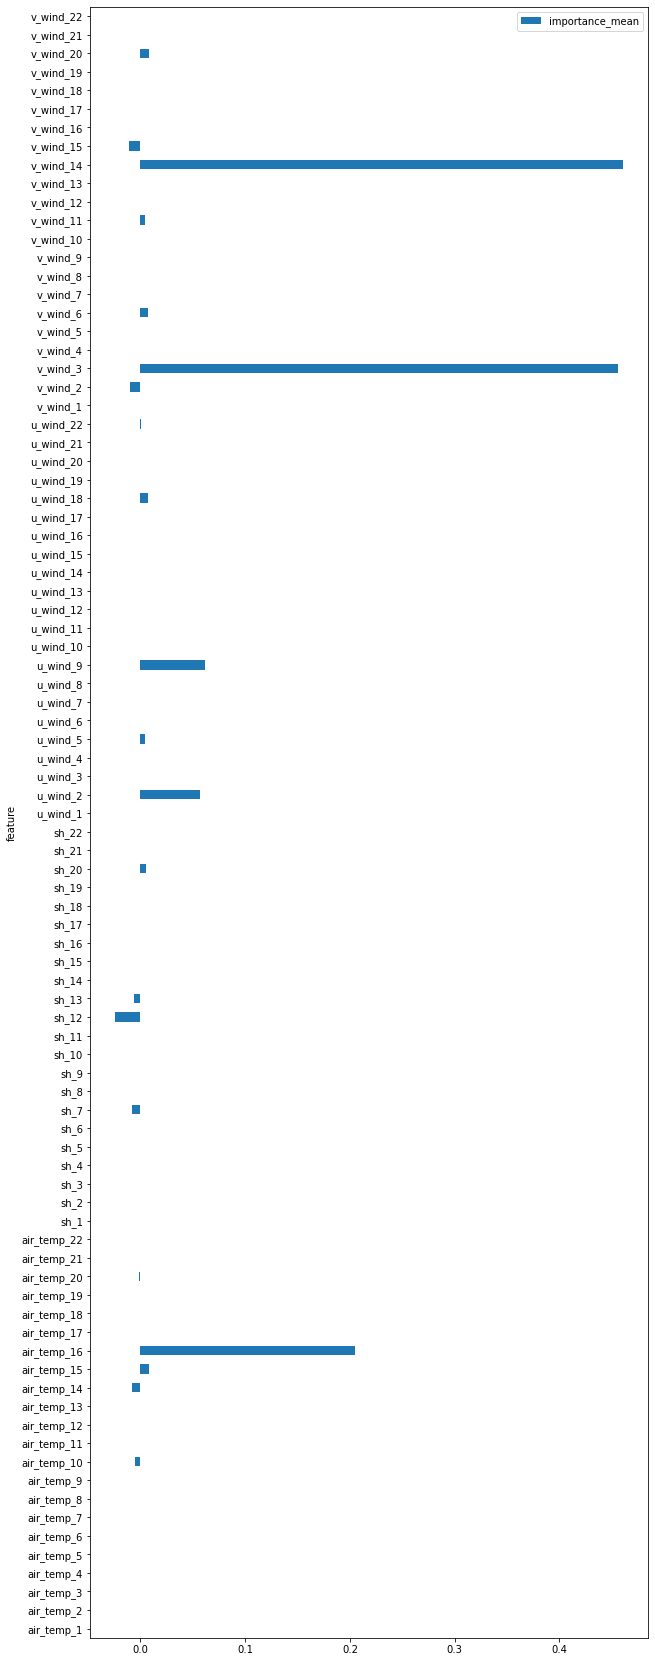

In [43]:
pandas.DataFrame({
    'feature': input_feature_names, 
    'importance_mean':  importances_dict_resampled['importances_mean']
}).plot.barh(x='feature',y='importance_mean',figsize=(10,30))

### Example - Experiment tracking

In [ ]:
import mlflow

## Examples of use
*UNDER  CONSTRUCTION*


## Next steps

### Reproducible Scaleable Machine Learning

Making use of the techniques described here, especially hyperparameter tuning, is very compute intensive and produces a lot of data to keep track of. Two sets of tools from the [MLOps](https://blogs.nvidia.com/blog/2020/09/03/what-is-mlops/) space including parallelisation tools, to run multiple training runs in parallel on a cluster, and experiment tracking or ML lifecycle tools, to keep track of which inputs and hyperparameters correspond to which trained model and the associated metrics and visualisations over the course of the experiment and provide evidence to build trust in subsequent deployment of ML based products.

Scalable ML
* [dask-ml](https://ml.dask.org/)
* [ray](https://www.ray.io/)

Experiment Tracking
* [ML Flow](https://mlflow.org/)

### Further machine learning overview tutorials
https://github.com/djgagne/ams-ml-python-course

### Interpretable/Explainable Machine Learning - Theory
* https://christophm.github.io/interpretable-ml-book/limo.html
* https://github.com/interpretml/interpret

Interpretable/Explainable Machine Learning - Practical Examples
Colab - What IF Tool (WIT)
* https://pair-code.github.io/what-if-tool/
* https://colab.research.google.com/github/pair-code/what-if-tool/blob/master/WIT_COMPAS_with_SHAP.ipynb#scrollTo=iywHwbJJkeYG
* https://github.com/neomatrix369/awesome-ai-ml-dl/blob/master/data/model-analysis-interpretation-explainability.md


## Dataset Info

### Falklands Rotors Challenge Dataset
Crown Copyright 2021 - This dataset was created by Met Office Chief Operational Meterologist Steve Ramsdale from Met Office forecast and observation data.
* Model Data - Met Office Global 10km resolution model
* Observations - made by meteorologists at Mount Pleasant airfield in the Falkland Islands.


## References

Hyperparameter search
* [Hyperparameter tuning with scikit-learn - Machine Larning Mastery](https://machinelearningmastery.com/hyperparameter-optimization-with-random-search-and-grid-search/)
* [scikit-learn docs](https://scikit-learn.org/stable/modules/grid_search.html#multimetric-grid-search)

Data Resampling
* [Imbalanced Learn docs](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&cad=rja&uact=8&ved=2ahUKEwiru8rfifT4AhUTQ8AKHWyYAmkQFnoECBQQAQ&url=https%3A%2F%2Fimbalanced-learn.org%2F&usg=AOvVaw1LZ6uQInqba1dPLNkmMvhL)
* [Introduction to SMOTE](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)

Feature Importance
* [Introduction to feature importance for interpretability - Towards Data Science](https://towardsdatascience.com/from-scratch-permutation-feature-importance-for-ml-interpretability-b60f7d5d1fe9)
* [scikit learn feature importance docs](https://scikit-learn.org/stable/modules/permutation_importance.html)

Experiment Tracking
* [ML Flow docs](https://www.mlflow.org/docs/latest/index.html)